In [1]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA, FactorAnalysis, SparsePCA, TruncatedSVD
except:
    !pip install matplotlib seaborn scikit-learn

try:
    import susiepca as susp
except:
    !pip install git+https://github.com/mancusolab/susiepca.git@main

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr

from sppcax.models import PFA
from sppcax import fit

div = sns.diverging_palette(250, 10, as_cmap=True)

jax.config.update("jax_enable_x64", True)

In [ ]:
z_dim = 4
Z, W, X = susp.sim.generate_sim(seed = 11, l_dim = 10, n_dim = 80, p_dim =160, z_dim = z_dim, effect_size = 1)

In [4]:
results = susp.infer.susie_pca(X, z_dim = 8, l_dim = 10, max_iter=200)

Iter [1] | ELBO = -19528.873 | E[logl] = -18448.247 | -KL[Z] = -846.171 | -KL[W] = -172.527 | -KL[G] = -61.928
Iter [2] | ELBO = -17947.451 | E[logl] = -16495.155 | -KL[Z] = -1152.195 | -KL[W] = -139.832 | -KL[G] = -160.269
Iter [3] | ELBO = -17367.716 | E[logl] = -15757.212 | -KL[Z] = -1306.239 | -KL[W] = -120.918 | -KL[G] = -183.347
Iter [4] | ELBO = -17004.570 | E[logl] = -15182.911 | -KL[Z] = -1503.176 | -KL[W] = -122.000 | -KL[G] = -196.482
Iter [5] | ELBO = -16563.355 | E[logl] = -14533.503 | -KL[Z] = -1666.909 | -KL[W] = -146.149 | -KL[G] = -216.794
Iter [6] | ELBO = -16417.028 | E[logl] = -14381.841 | -KL[Z] = -1686.444 | -KL[W] = -129.121 | -KL[G] = -219.622
Iter [7] | ELBO = -16368.908 | E[logl] = -14349.856 | -KL[Z] = -1671.892 | -KL[W] = -127.794 | -KL[G] = -219.366
Iter [8] | ELBO = -16338.976 | E[logl] = -14340.997 | -KL[Z] = -1654.005 | -KL[W] = -127.121 | -KL[G] = -216.853
Iter [9] | ELBO = -16305.569 | E[logl] = -14329.061 | -KL[Z] = -1638.428 | -KL[W] = -126.156 | -KL

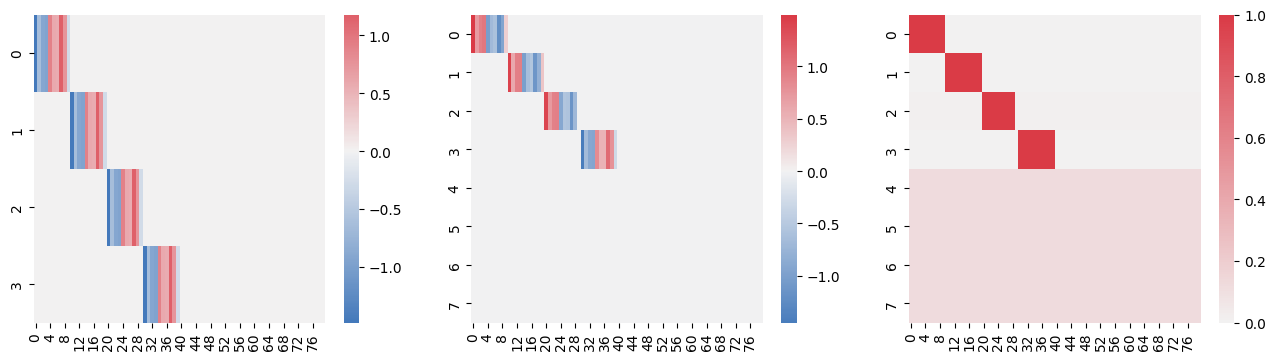

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);

Text(0.5, 1.0, 'Sparse PCA')

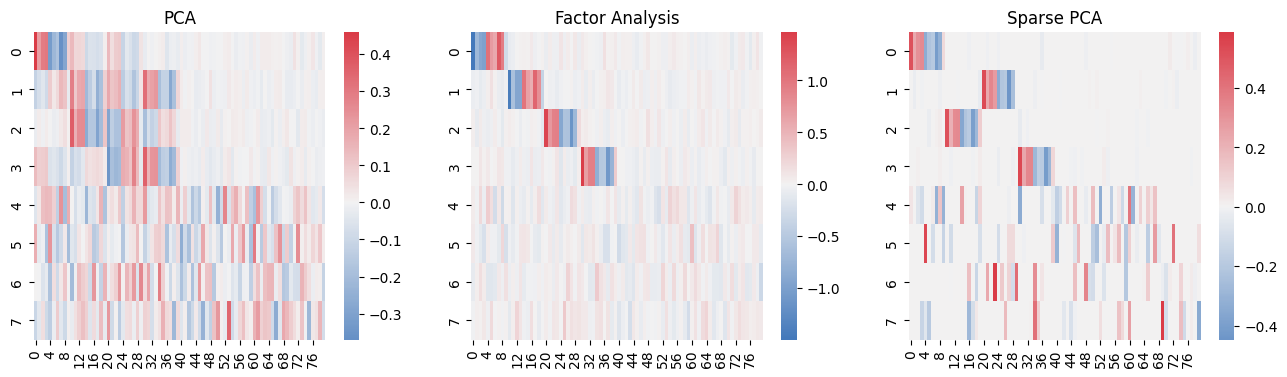

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
u, s, v = jnp.linalg.svd(X, full_matrices=False)
z_dim = 8

pca_z= (u * s[None])[..., :z_dim]

pca_w = v[:z_dim]

pca = TruncatedSVD(n_components=z_dim)
res = pca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[0])
axes[0].set_title('PCA')

fa = FactorAnalysis(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[1])
axes[1].set_title('Factor Analysis')

spca = SparsePCA(n_components=z_dim)
res = spca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[2])
axes[2].set_title('Sparse PCA')

In [7]:
n_components = 8
n_features = 80
key = jr.PRNGKey(1987)
fit_models = []
elbos = []
for bmr_e_step in [False, True]:
    for bmr_m_step in [False, True]:
        for optimize_with_bmr in [False, True]:
            model = PFA(
                n_components=n_components,
                n_features=n_features,
                optimize_with_bmr=optimize_with_bmr,
                bmr_m_step=bmr_m_step,
                bmr_e_step=bmr_e_step,
                bmr_e_step_opts=('max_iter', 2, 'pi', 0.2)
            )
            
            key, _key = jr.split(key)
            fm, elbs = fit(model, X, tol=1e-3, n_iter=256, bmr_frequency=32, key=_key)
            fit_models.append(fm)
            elbos.append(elbs)
            print([bmr_e_step, bmr_m_step, optimize_with_bmr], elbos[-1][-1], len(elbos[-1]))

[False, False, False] -43789.53173323662 256
[False, False, True] -43424.50260979531 256
[False, True, False] -43111.48379484279 198
[False, True, True] -42326.268843226346 128
[True, False, False] -43150.38964698559 256
[True, False, True] -43127.67646062283 256
[True, True, False] -42907.773046786715 256
[True, True, True] -41969.77915479886 256


In [8]:
elbos[-2]

[Array(-67506.00221148, dtype=float64),
 Array(-49064.66973496, dtype=float64),
 Array(-46644.83603671, dtype=float64),
 Array(-44566.41914942, dtype=float64),
 Array(-44178.46323451, dtype=float64),
 Array(-44112.53653716, dtype=float64),
 Array(-44066.89780444, dtype=float64),
 Array(-44035.37448573, dtype=float64),
 Array(-44016.53302041, dtype=float64),
 Array(-44005.1264515, dtype=float64),
 Array(-43997.14842714, dtype=float64),
 Array(-43990.75094663, dtype=float64),
 Array(-43985.19007167, dtype=float64),
 Array(-43980.1263599, dtype=float64),
 Array(-43975.36720618, dtype=float64),
 Array(-43970.78239044, dtype=float64),
 Array(-43966.27491742, dtype=float64),
 Array(-43961.76923759, dtype=float64),
 Array(-43957.20543109, dtype=float64),
 Array(-43952.53590824, dtype=float64),
 Array(-43947.72350056, dtype=float64),
 Array(-43942.74048616, dtype=float64),
 Array(-43937.56829113, dtype=float64),
 Array(-43932.19766995, dtype=float64),
 Array(-43926.62918109, dtype=float64),
 A

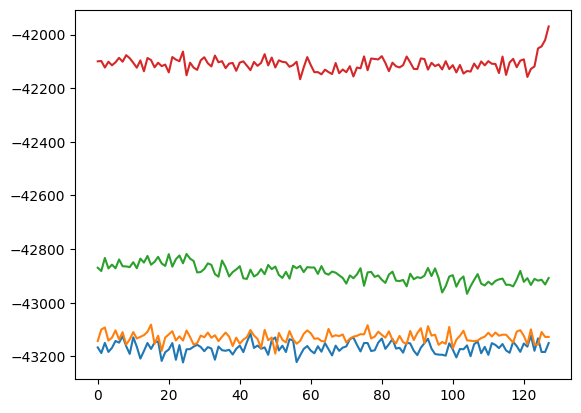

In [9]:
for elbo in elbos[4:]:
    plt.plot(elbo[-128:])

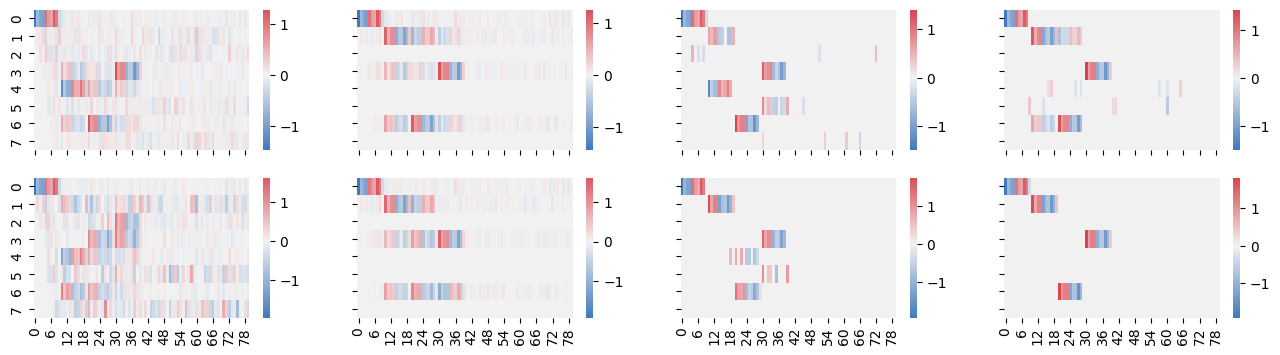

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    W = fit_models[i].W_dist.mvn.mean.T
    sns.heatmap(W, cmap = div, fmt = ".2f", center = 0, ax=ax)


In [26]:
def generate_data(key, snr=1.):
    n_fact = 6
    key, _key = jr.split(key)
    z = jr.normal(_key, shape=(80, n_fact))
    W = []
    tmp = jnp.arange(800)
    for i in [0, 400, 500, 600, 680, 740]:
        W.append(1.0 * (tmp >= i))
    W = jnp.stack(W, 0) * jr.normal(_key, shape=(n_fact, 800))
    loc = z @ W
    psi = snr / jnp.var(loc, 0)

    eps = jr.normal(_key, shape=(80, 800))

    return (loc + eps)/jnp.sqrt(psi), W, z
2

key = jr.PRNGKey(0)

X, W, Z = generate_data(key, snr=20.)
print(X.shape, Z.shape, W.shape)

(80, 800) (80, 6) (6, 800)


In [27]:
results = susp.infer.susie_pca(X, z_dim = 6, l_dim = 64, max_iter=500)

Iter [1] | ELBO = -23604.181 | E[logl] = -22632.737 | -KL[Z] = -309.957 | -KL[W] = -557.449 | -KL[G] = -104.038
Iter [2] | ELBO = -16912.099 | E[logl] = -14704.258 | -KL[Z] = -863.675 | -KL[W] = -781.469 | -KL[G] = -562.696
Iter [3] | ELBO = -9622.198 | E[logl] = -6540.317 | -KL[Z] = -1101.373 | -KL[W] = -896.518 | -KL[G] = -1083.990
Iter [4] | ELBO = -5741.472 | E[logl] = -2513.987 | -KL[Z] = -1220.949 | -KL[W] = -720.463 | -KL[G] = -1286.073
Iter [5] | ELBO = -3214.368 | E[logl] = 467.311 | -KL[Z] = -1434.583 | -KL[W] = -802.368 | -KL[G] = -1444.728
Iter [6] | ELBO = -596.646 | E[logl] = 3639.413 | -KL[Z] = -1556.663 | -KL[W] = -981.952 | -KL[G] = -1697.443
Iter [7] | ELBO = 1592.005 | E[logl] = 5938.509 | -KL[Z] = -1606.556 | -KL[W] = -906.522 | -KL[G] = -1833.425
Iter [8] | ELBO = 3324.343 | E[logl] = 7870.993 | -KL[Z] = -1654.899 | -KL[W] = -937.483 | -KL[G] = -1954.267
Iter [9] | ELBO = 4497.546 | E[logl] = 9178.573 | -KL[Z] = -1680.866 | -KL[W] = -962.849 | -KL[G] = -2037.313
It

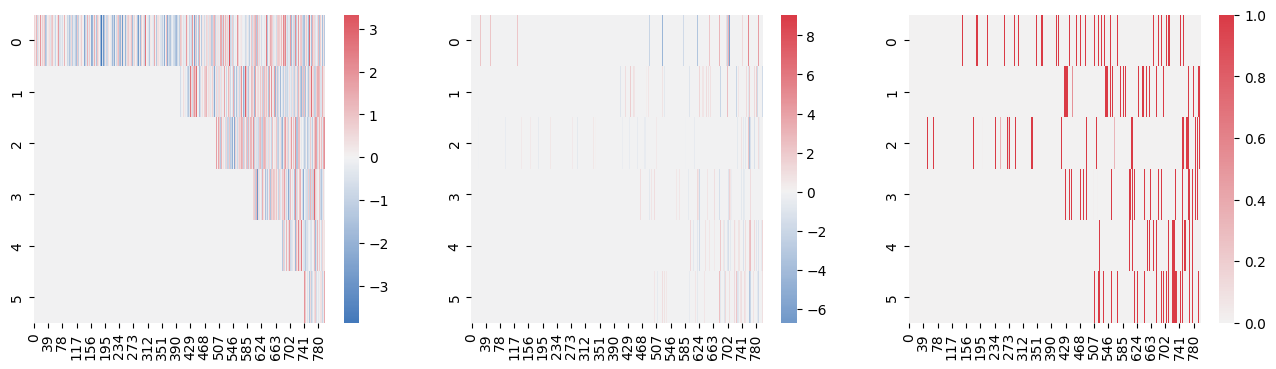

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Heatmap of true loading matrix
sns.heatmap(W, cmap = div, fmt = ".2f",center = 0, ax=axes[0]);

# Heatmap of estimate loading matrix
W_hat = results.W
sns.heatmap(W_hat, cmap = div, fmt = ".2f", center = 0, ax=axes[1]);

# Heatmap of PIPs
pip = results.pip
sns.heatmap(pip, cmap = div, fmt = ".2f", center = 0, ax=axes[2]);

Text(0.5, 1.0, 'Sparse PCA')

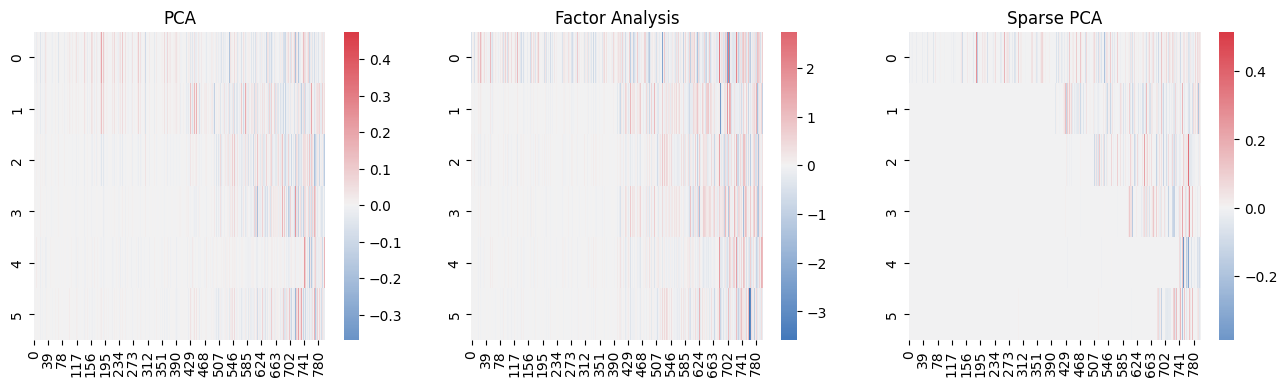

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

z_dim = 6
pca = TruncatedSVD(n_components=z_dim)
res = pca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[0])
axes[0].set_title('PCA')

fa = FactorAnalysis(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[1])
axes[1].set_title('Factor Analysis')

spca = SparsePCA(n_components=z_dim)
res = spca.fit(X)

sns.heatmap(res.components_, cmap = div, fmt = ".2f", center = 0, ax=axes[2])
axes[2].set_title('Sparse PCA')

In [42]:
n_components = 6
n_features = 800
key = jr.PRNGKey(5890)
fit_models = []
elbos = []
for bmr_e_step in [False, True]:
    for bmr_m_step in [False, True]:
        for optimize_with_bmr in [False, True]:
            model = PFA(
                n_components=n_components,
                n_features=n_features,
                optimize_with_bmr=optimize_with_bmr,
                bmr_m_step=bmr_m_step,
                bmr_e_step=bmr_e_step,
                bmr_e_step_opts=('max_iter', 2, 'pi', 0.2)
            )
            
            key, _key = jr.split(key)
            fm, elbs = fit(model, X, tol=1e-3, n_iter=512, bmr_frequency=64, key=_key)
            fit_models.append(fm)
            elbos.append(elbs)
            print([bmr_e_step, bmr_m_step, optimize_with_bmr], elbos[-1][-1], len(elbos[-1]))

[False, False, False] -26676.610427294632 512
[False, False, True] -14236.489971772964 512
[False, True, False] -28010.16142508682 512
[False, True, True] -5432.67024738124 512
[True, False, False] -26529.254438675416 512
[True, False, True] -13970.268076597371 512
[True, True, False] -26319.552965613468 512
[True, True, True] -5287.870071399074 512


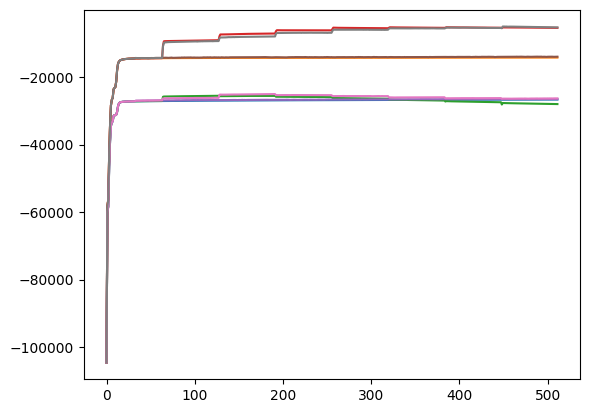

In [46]:
for elbo in elbos:
    plt.plot(elbo)

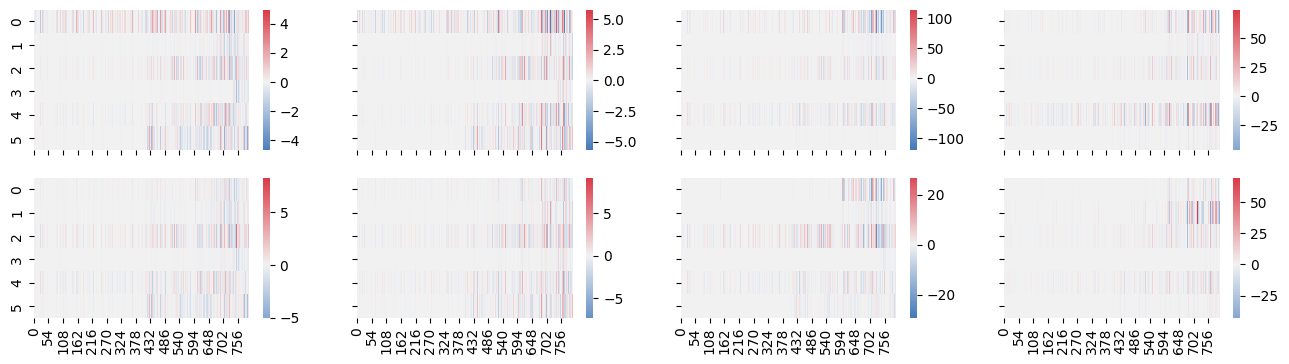

In [47]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    W = fit_models[i].W_dist.mvn.mean.T
    sns.heatmap(W, cmap = div, fmt = ".2f", center = 0, ax=ax)


In [43]:
for fm in fit_models:
    print(jnp.sort(fm.W_dist.mvn.mask.sum(0)))


[795 796 797 798 799 800]
[795 796 797 798 799 800]
[ 40 168 273 383 491 560]
[ 41 177 294 375 600 630]
[795 796 797 798 799 800]
[795 796 797 798 799 800]
[ 39 135 185 279 513 530]
[ 41 277 286 335 610 620]
